<a href="https://colab.research.google.com/github/Anupatnam/Iris-Pupil-Ratio-Detection/blob/main/Iris_Pupil_Ratio_Detection_using_unet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

# Define dataset directories
dataset_root = "/content/drive/MyDrive/Dataset"  # Root folder
subfolders = ["train", "test", "valid"]  # The three subfolders
mask_root = "/content/drive/MyDrive/Dataset/Masks"  # Where to save masks

def convert_voc_to_rgb_masks(dataset_root, subfolders, mask_root, class_names=["iris", "pupille"]):
    if not os.path.exists(mask_root):
        os.makedirs(mask_root)

    total_masks = 0  # Track the number of masks generated

    for subfolder in subfolders:
        dataset_dir = os.path.join(dataset_root, subfolder)  # e.g., Dataset/train
        mask_dir = os.path.join(mask_root, subfolder)  # Save masks in separate subfolders

        if not os.path.exists(mask_dir):
            os.makedirs(mask_dir)

        for file in os.listdir(dataset_dir):
            if not file.endswith(".xml"):
                continue  # Ignore non-XML files

            xml_path = os.path.join(dataset_dir, file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            filename = root.find("filename")
            if filename is None:
                print(f"❌ ERROR: No 'filename' in {file}")
                continue

            image_path = os.path.join(dataset_dir, filename.text)
            image = cv2.imread(image_path)

            if image is None:
                print(f"❌ Image not found: {filename.text} in {subfolder}")
                continue

            height, width, _ = image.shape
            mask = np.zeros((height, width, 3), dtype=np.uint8)

            found_labels = []  # Track detected labels

            for obj in root.findall("object"):
                label = obj.find("name").text
                found_labels.append(label)

                bbox = obj.find("bndbox")
                x_min, y_min, x_max, y_max = (
                    int(bbox.find("xmin").text),
                    int(bbox.find("ymin").text),
                    int(bbox.find("xmax").text),
                    int(bbox.find("ymax").text),
                )

                if label == "iris":
                    mask[y_min:y_max, x_min:x_max] = [0, 255, 0]  # Green for iris
                elif label == "pupille":
                    mask[y_min:y_max, x_min:x_max] = [255, 0, 0]  # Red for pupil

            if found_labels:
                mask_filename = filename.text.replace(".jpg", ".png")
                cv2.imwrite(os.path.join(mask_dir, mask_filename), mask)
                print(f"✅ Mask saved: {mask_filename} in {subfolder}")
                total_masks += 1
            else:
                print(f"⚠️ No valid labels in {file}")

    print(f"\n🎉 Completed! {total_masks} masks generated across train/test/valid.")

# Run the updated function
convert_voc_to_rgb_masks(dataset_root, subfolders, mask_root)



✅ Mask saved: aeval1_bmp.rf.5713f74099a031c4bb3c7ec9d9c1045e.png in train
✅ Mask saved: chongpkl1_bmp.rf.d532e3fb7c18afd70f79e9a62f5c9a7d.png in train
✅ Mask saved: chingycr5_bmp.rf.7ea29edd27dd19e06d759f7d07e90753.png in train
✅ Mask saved: chingycr1_bmp.rf.a313fed83a7cd6817f767e3ef1d5e37a.png in train
✅ Mask saved: chingycl5_bmp.rf.ca01ecda4a2e285cbf0f711d8975d66f.png in train
✅ Mask saved: chingycl4_bmp.rf.805b07818b83467293cfe6b4208b39c6.png in train
✅ Mask saved: chingycl3_bmp.rf.ddc26be44fd3f534e5c09abe5bbfb8b1.png in train
✅ Mask saved: chingycl2_bmp.rf.8099599e767dadf85fe7b9b6c2bc9d22.png in train
✅ Mask saved: chingycl1_bmp.rf.77dee7d85ff91cd33c9eb27ae80372ab.png in train
✅ Mask saved: bryanr5_bmp.rf.aa55dd95a7b80e5e4592fec8b1cdcb55.png in train
✅ Mask saved: aeval4_bmp.rf.19fa086d49f1380d44b86607fb15a4f1.png in train
✅ Mask saved: bryanr1_bmp.rf.b2ce9842ecc70b29592c9602add9f631.png in train
✅ Mask saved: bryanl5_bmp.rf.31800fff04a7b4a8a091d842ff61b233.png in train
✅ Mask save

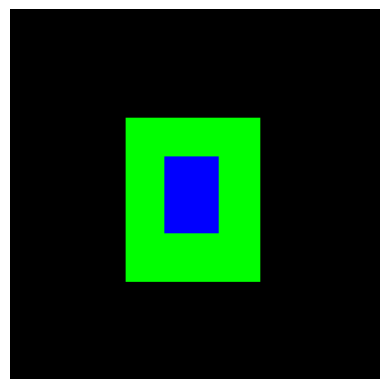

In [ ]:
import cv2
import matplotlib.pyplot as plt

sample_mask_path = "/content/drive/MyDrive/Dataset/Masks/train/aeval1_bmp.rf.5713f74099a031c4bb3c7ec9d9c1045e.png"  # Change filename accordingly
sample_mask = cv2.imread(sample_mask_path)

if sample_mask is not None:
    plt.imshow(cv2.cvtColor(sample_mask, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
else:
    print("❌ Mask file not found!")


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array

# Define dataset paths
image_dir = "/content/drive/MyDrive/Dataset/train"  # Update with train folder
mask_dir = "/content/drive/MyDrive/Dataset/Masks/train"

# Image & mask dimensions (update if needed)
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 3  # Background, Iris, Pupil

# Mapping colors to class labels
COLOR_MAP = {
    (0, 0, 0): 0,  # Background
    (0, 255, 0): 1,  # Iris (Green)
    (255, 0, 0): 2  # Pupil (Red)
}

# Function to preprocess masks
def preprocess_mask(mask):
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask_class = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

    for color, label in COLOR_MAP.items():
        mask_class[(mask == color).all(axis=-1)] = label

    return to_categorical(mask_class, num_classes=NUM_CLASSES).reshape((IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES))


# Function to load dataset
def load_dataset(image_dir, mask_dir):
    images, masks = [], []
    for file in os.listdir(image_dir):
        if file.endswith(".jpg") or file.endswith(".png"):  # Adjust for your dataset
            img_path = os.path.join(image_dir, file)
            mask_path = os.path.join(mask_dir, file.replace(".jpg", ".png"))

            # Load & resize
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path)

            if img is None or mask is None:
                print(f"Skipping {file}, missing image or mask.")
                continue

            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT)) / 255.0  # Normalize
            mask = preprocess_mask(mask)

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# Load training data
X_train, Y_train = load_dataset(image_dir, mask_dir)

print(f"✅ Dataset Loaded: {X_train.shape}, {Y_train.shape}")


✅ Dataset Loaded: (315, 256, 256, 3), (315, 256, 256, 3)


In [ ]:
print("Unique values in Y_train_gray:", np.unique(Y_train_gray))


Unique values in Y_train_gray: [0 1 2]


In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert RGB mask to grayscale (if needed)
Y_train_gray = np.argmax(Y_train, axis=-1)  # Convert to 1-channel integer mask

# Ensure values are only 0 (background) and 1 (iris+pupil)
Y_train_gray[Y_train_gray > 1] = 1  # Convert all values greater than 1 to 1

# Convert grayscale mask to one-hot encoding with 2 classes
Y_train_onehot = to_categorical(Y_train_gray, num_classes=2)

print(f"Updated Y_train shape: {Y_train_onehot.shape}")  # Should be (None, 256, 256, 2)


Updated Y_train shape: (315, 256, 256, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

# Define U-Net Model
def build_unet(input_shape=(256, 256, 3), num_classes=2):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(512, (3, 3), activation="relu", padding="same")(conv4)

    # Decoder
    up5 = UpSampling2D((2, 2))(conv4)
    up5 = Concatenate()([up5, conv3])
    conv5 = Conv2D(256, (3, 3), activation="relu", padding="same")(up5)
    conv5 = Conv2D(256, (3, 3), activation="relu", padding="same")(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    up6 = Concatenate()([up6, conv2])
    conv6 = Conv2D(128, (3, 3), activation="relu", padding="same")(up6)
    conv6 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    up7 = Concatenate()([up7, conv1])
    conv7 = Conv2D(64, (3, 3), activation="relu", padding="same")(up7)
    conv7 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv7)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(conv7)

    model = Model(inputs, outputs)
    return model

# Create model
unet_model = build_unet()

# Compile model
unet_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Model checkpoint to save the best model
checkpoint = ModelCheckpoint("/content/drive/MyDrive/best_model.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",
                             verbose=1)

# Train the model
history = unet_model.fit(X_train, Y_train_onehot, batch_size=16, epochs=10,
                         validation_split=0.2, callbacks=[checkpoint])

# Save final model
unet_model.save("/content/drive/MyDrive/final_iris_pupil_unet.h5")

print("✅ Model training complete & saved successfully!")

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7087 - loss: 0.8783   
Epoch 1: val_accuracy improved from -inf to 0.84575, saving model to /content/drive/MyDrive/best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 165s 6s/step - accuracy: 0.7149 - loss: 0.8641 - val_accuracy: 0.8457 - val_loss: 0.3439
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8597 - loss: 0.2888
Epoch 2: val_accuracy did not improve from 0.84575
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 680ms/step - accuracy: 0.8597 - loss: 0.2886 - val_accuracy: 0.8457 - val_loss: 0.3028
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8649 - loss: 0.2612
Epoch 3: val_accuracy improved from 0.84575 to 0.87780, saving model to /content/drive/MyDrive/best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 783ms/step - accuracy: 0.8655 - loss: 0.2607 - val_accuracy: 0.8778 - val_loss: 0.2638
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9162 - loss: 0.2125
Epoch 4: val_accuracy improved from 0.87780 to 0.89382, saving model to /content/drive/MyDrive/best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 794ms/step - accuracy: 0.9163 - loss: 0.2122 - val_accuracy: 0.8938 - val_loss: 0.2461
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9221 - loss: 0.1893
Epoch 5: val_accuracy improved from 0.89382 to 0.93122, saving model to /content/drive/MyDrive/best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 808ms/step - accuracy: 0.9223 - loss: 0.1890 - val_accuracy: 0.9312 - val_loss: 0.2061
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9509 - loss: 0.1365
Epoch 6: val_accuracy improved from 0.93122 to 0.95487, saving model to /content/drive/MyDrive/best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 806ms/step - accuracy: 0.9514 - loss: 0.1353 - val_accuracy: 0.9549 - val_loss: 0.1359
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9715 - loss: 0.0837
Epoch 7: val_accuracy improved from 0.95487 to 0.96040, saving model to /content/drive/MyDrive/best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 784ms/step - accuracy: 0.9715 - loss: 0.0837 - val_accuracy: 0.9604 - val_loss: 0.1360
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9733 - loss: 0.0724
Epoch 8: val_accuracy improved from 0.96040 to 0.96312, saving model to /content/drive/MyDrive/best_model.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 799ms/step - accuracy: 0.9733 - loss: 0.0724 - val_accuracy: 0.9631 - val_loss: 0.1298
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9735 - loss: 0.0642
Epoch 9: val_accuracy did not improve from 0.96312
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 716ms/step - accuracy: 0.9736 - loss: 0.0641 - val_accuracy: 0.9606 - val_loss: 0.1148
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9764 - loss: 0.0573
Epoch 10: val_accuracy did not improve from 0.96312
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 715ms/step - accuracy: 0.9764 - loss: 0.0573 - val_accuracy: 0.9625 - val_loss: 0.1128


✅ Model training complete & saved successfully!


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset into train & validation sets (80-20 split)
X_train, X_valid, Y_train_onehot, Y_valid_onehot = train_test_split(
    X_train, Y_train_onehot, test_size=0.2, random_state=42
)

print(f"Training Data: {X_train.shape}, {Y_train_onehot.shape}")
print(f"Validation Data: {X_valid.shape}, {Y_valid_onehot.shape}")


Training Data: (252, 256, 256, 3), (252, 256, 256, 2)
Validation Data: (63, 256, 256, 3), (63, 256, 256, 2)


In [ ]:
loss, accuracy = unet_model.evaluate(X_valid, Y_valid_onehot)
print(f"✅ Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 61s 31s/step - accuracy: 0.9730 - loss: 0.0655
✅ Validation Loss: 0.0696, Validation Accuracy: 0.9716


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a test image (update path if needed)
test_img_path = "/content/drive/MyDrive/Dataset/download.jpg"  # Change this to an actual test image path
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert to RGB
test_img = cv2.resize(test_img, (256, 256))  # Resize to match model input
test_img = test_img / 255.0  # Normalize
test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

# Make prediction
pred_mask = unet_model.predict(test_img)[0]  # Get first image's prediction
pred_mask = np.argmax(pred_mask, axis=-1)  # Convert from one-hot to class labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
print("Predicted Mask Shape:", predicted_mask.shape)
print("Unique values in predicted mask:", np.unique(predicted_mask))


Predicted Mask Shape: (1, 256, 256)
Unique values in predicted mask: [0 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


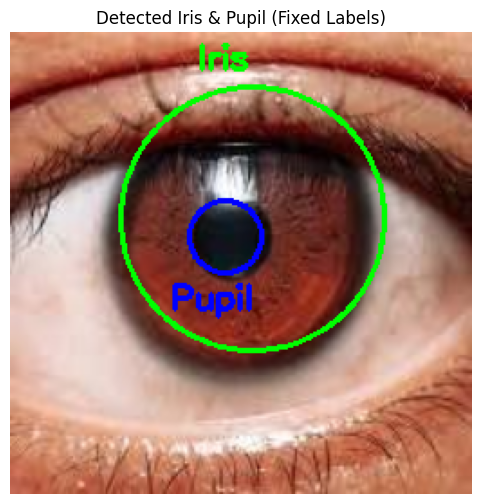

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the test image
image_path = "/content/drive/MyDrive/Dataset/download.jpg"  # Update with your image path
new_test_image = cv2.imread(image_path)
new_test_image = cv2.resize(new_test_image, (256, 256))  # Resize to match model input
original_image = new_test_image.copy()  # Keep a copy for visualization

# Normalize and predict
new_test_image = new_test_image / 255.0  # Normalize
new_test_image = np.expand_dims(new_test_image, axis=0)  # Add batch dimension
predicted_mask = unet_model.predict(new_test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to binary and remove batch dim

# Convert predicted mask to uint8
binary_mask = (predicted_mask * 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

iris_contour = None
pupil_contour = None

# Sort contours by area (largest should be iris)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

if len(sorted_contours) > 0:
    iris_contour = sorted_contours[0]  # Largest contour (Iris)

    # Extract iris region
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, [iris_contour], -1, 255, thickness=cv2.FILLED)
    iris_region = cv2.bitwise_and(binary_mask, binary_mask, mask=mask)

    # Convert iris region to grayscale for pupil detection
    gray_iris = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    pupil_region = cv2.bitwise_and(gray_iris, gray_iris, mask=mask)

    # Use HoughCircles to detect the pupil more accurately
    circles = cv2.HoughCircles(pupil_region, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=3, maxRadius=30)  # Smaller radii

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            x, y, r = i
            iris_x, iris_y, iris_w, iris_h = cv2.boundingRect(iris_contour)

            # Ensure the detected pupil is within the iris
            if iris_x < x < iris_x + iris_w and iris_y < y < iris_y + iris_h:
                pupil_contour = (x, y, r)
                break

# Draw iris circle using centroid & radius
if iris_contour is not None:
    M = cv2.moments(iris_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        radius = int(0.75 * np.sqrt(cv2.contourArea(iris_contour) / np.pi))  # Smaller radius
        cv2.circle(original_image, (cx, cy), radius, (0, 255, 0), 2)  # Green for iris

        # Move iris label **above** the iris
        iris_label_x = cx - 30
        iris_label_y = cy - radius - 10  # Move text higher
        cv2.putText(original_image, "Iris", (iris_label_x, iris_label_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Draw pupil circle using HoughCircles
if pupil_contour is not None:
    x, y, r = pupil_contour
    cv2.circle(original_image, (x, y), max(2, r - 5), (255, 0, 0), 2)  # Smaller pupil circle

    # Move pupil label **below** the pupil
    pupil_label_x = x - 30
    pupil_label_y = y + r + 15  # Move text lower
    cv2.putText(original_image, "Pupil", (pupil_label_x, pupil_label_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Show results
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Detected Iris & Pupil (Fixed Labels)")
plt.axis("off")
plt.show()



In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_path = "/content/drive/MyDrive/final_iris_pupil_unet.h5"
unet_model = load_model(model_path)

# Now you can use `unet_model.predict()` without retraining


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Iris-to-Pupil Ratio: 1.46


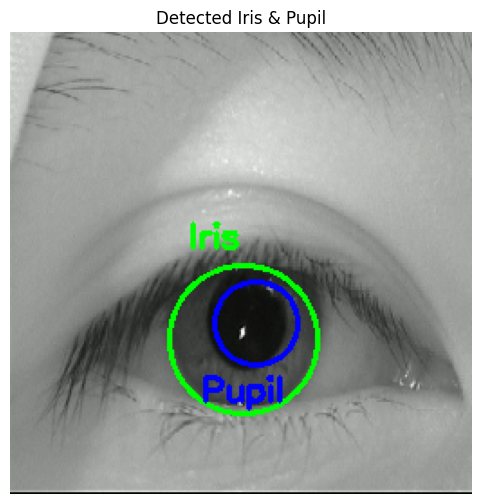

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/content/drive/MyDrive/final_iris_pupil_unet.h5"
unet_model = load_model(model_path)

# Load and preprocess the test image
image_path = "/content/drive/MyDrive/Dataset/download.jpg"
new_test_image = cv2.imread(image_path)
new_test_image = cv2.resize(new_test_image, (256, 256))
original_image = new_test_image.copy()
new_test_image = new_test_image / 255.0  # Normalize
new_test_image = np.expand_dims(new_test_image, axis=0)  # Add batch dimension

# Predict mask
predicted_mask = unet_model.predict(new_test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to binary mask
binary_mask = (predicted_mask * 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

iris_contour = None
pupil_contour = None
iris_radius = None
pupil_radius = None

if len(sorted_contours) > 0:
    iris_contour = sorted_contours[0]  # Largest contour (Iris)

    # Extract iris region
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, [iris_contour], -1, 255, thickness=cv2.FILLED)
    gray_iris = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    pupil_region = cv2.bitwise_and(gray_iris, gray_iris, mask=mask)

    # Detect pupil using HoughCircles
    circles = cv2.HoughCircles(pupil_region, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=3, maxRadius=30)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            x, y, r = i
            iris_x, iris_y, iris_w, iris_h = cv2.boundingRect(iris_contour)
            if iris_x < x < iris_x + iris_w and iris_y < y < iris_y + iris_h:
                pupil_contour = (x, y, r)
                pupil_radius = r
                break

# Draw iris circle using centroid & radius
if iris_contour is not None:
    M = cv2.moments(iris_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        iris_radius = int(0.75 * np.sqrt(cv2.contourArea(iris_contour) / np.pi))
        cv2.circle(original_image, (cx, cy), iris_radius, (0, 255, 0), 2)  # Green for iris
        cv2.putText(original_image, "Iris", (cx - 30, cy - iris_radius - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Draw pupil circle using HoughCircles
if pupil_contour is not None:
    x, y, r = pupil_contour
    cv2.circle(original_image, (x, y), max(2, r - 5), (255, 0, 0), 2)
    cv2.putText(original_image, "Pupil", (x - 30, y + r + 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Calculate Iris-to-Pupil Ratio
if iris_radius is not None and pupil_radius is not None and pupil_radius > 0:
    iris_to_pupil_ratio = iris_radius / pupil_radius
    print(f"✅ Iris-to-Pupil Ratio: {iris_to_pupil_ratio:.2f}")

# Show results
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Iris & Pupil")
plt.axis("off")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Iris-to-Pupil Ratio: 1.64


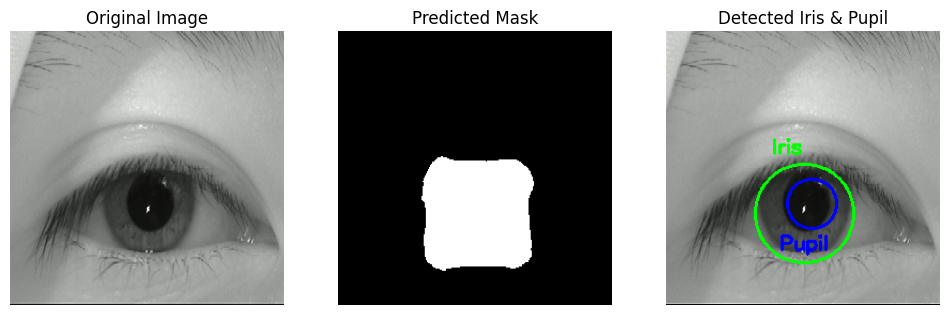

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the test image
image_path = "/content/drive/MyDrive/WhatsApp Image 2025-02-16 at 7.41.55 PM (1).jpeg"  # Update with your image path
new_test_image = cv2.imread(image_path)
new_test_image = cv2.resize(new_test_image, (256, 256))  # Resize to match model input
original_image = new_test_image.copy()  # Keep a copy for visualization

# Normalize and predict
new_test_image = new_test_image / 255.0  # Normalize
new_test_image = np.expand_dims(new_test_image, axis=0)  # Add batch dimension
predicted_mask = unet_model.predict(new_test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to binary and remove batch dim

# Convert predicted mask to uint8
binary_mask = (predicted_mask * 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

iris_contour = None
pupil_contour = None
iris_radius = None
pupil_radius = None

# Sort contours by area (largest should be iris)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

if len(sorted_contours) > 0:
    iris_contour = sorted_contours[0]  # Largest contour (Iris)

    # Extract iris region
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, [iris_contour], -1, 255, thickness=cv2.FILLED)
    iris_region = cv2.bitwise_and(binary_mask, binary_mask, mask=mask)

    # Convert iris region to grayscale for pupil detection
    gray_iris = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    pupil_region = cv2.bitwise_and(gray_iris, gray_iris, mask=mask)

    # Use HoughCircles to detect the pupil more accurately
    circles = cv2.HoughCircles(pupil_region, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=3, maxRadius=30)  # Smaller radii

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            x, y, r = i
            iris_x, iris_y, iris_w, iris_h = cv2.boundingRect(iris_contour)

            # Ensure the detected pupil is within the iris
            if iris_x < x < iris_x + iris_w and iris_y < y < iris_y + iris_h:
                pupil_contour = (x, y, r)
                pupil_radius = r  # Store pupil radius
                break

# Draw iris circle using centroid & radius
if iris_contour is not None:
    M = cv2.moments(iris_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        iris_radius = int(0.85 * np.sqrt(cv2.contourArea(iris_contour) / np.pi))  # Larger radius
        cv2.circle(original_image, (cx, cy), iris_radius, (0, 255, 0), 2)  # Green for iris

        # Move iris label **above** the iris
        iris_label_x = cx - 30
        iris_label_y = cy - iris_radius - 10  # Move text higher
        cv2.putText(original_image, "Iris", (iris_label_x, iris_label_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Draw pupil circle using HoughCircles
if pupil_contour is not None:
    x, y, r = pupil_contour
    cv2.circle(original_image, (x, y), max(2, r - 5), (255, 0, 0), 2)  # Smaller pupil circle

    # Move pupil label **below** the pupil
    pupil_label_x = x - 30
    pupil_label_y = y + r + 15  # Move text lower
    cv2.putText(original_image, "Pupil", (pupil_label_x, pupil_label_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Calculate Iris-to-Pupil Ratio (Only print, don't display on image)
if iris_radius is not None and pupil_radius is not None and pupil_radius > 0:
    iris_to_pupil_ratio = iris_radius / pupil_radius
    print(f"✅ Iris-to-Pupil Ratio: {iris_to_pupil_ratio:.2f}")

# Visualization
plt.figure(figsize=(12, 6))

# Show original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Show predicted mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

# Show processed image with detections
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Iris & Pupil")
plt.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
✅ Iris-to-Pupil Ratio: 1.57


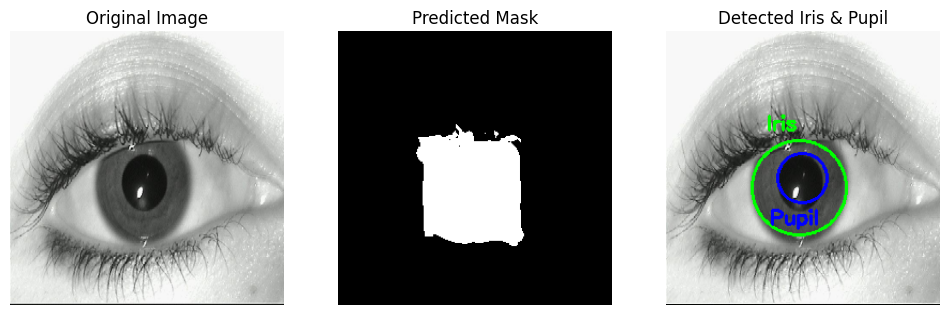

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the test image
image_path = "/content/drive/MyDrive/WhatsApp Image 2025-02-16 at 7.41.55 PM.jpeg"  # Update with your image path
new_test_image = cv2.imread(image_path)
new_test_image = cv2.resize(new_test_image, (256, 256))  # Resize to match model input
original_image = new_test_image.copy()  # Keep a copy for visualization

# Normalize and predict
new_test_image = new_test_image / 255.0  # Normalize
new_test_image = np.expand_dims(new_test_image, axis=0)  # Add batch dimension
predicted_mask = unet_model.predict(new_test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to binary and remove batch dim

# Convert predicted mask to uint8
binary_mask = (predicted_mask * 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

iris_contour = None
pupil_contour = None
iris_radius = None
pupil_radius = None

# Sort contours by area (largest should be iris)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

if len(sorted_contours) > 0:
    iris_contour = sorted_contours[0]  # Largest contour (Iris)

    # Extract iris region
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, [iris_contour], -1, 255, thickness=cv2.FILLED)
    iris_region = cv2.bitwise_and(binary_mask, binary_mask, mask=mask)

    # Convert iris region to grayscale for pupil detection
    gray_iris = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    pupil_region = cv2.bitwise_and(gray_iris, gray_iris, mask=mask)

    # Use HoughCircles to detect the pupil more accurately
    circles = cv2.HoughCircles(pupil_region, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=3, maxRadius=30)  # Smaller radii

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            x, y, r = i
            iris_x, iris_y, iris_w, iris_h = cv2.boundingRect(iris_contour)

            # Ensure the detected pupil is within the iris
            if iris_x < x < iris_x + iris_w and iris_y < y < iris_y + iris_h:
                pupil_contour = (x, y, r)
                pupil_radius = r  # Store pupil radius
                break

# Draw iris circle using centroid & radius
if iris_contour is not None:
    M = cv2.moments(iris_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        iris_radius = int(0.85 * np.sqrt(cv2.contourArea(iris_contour) / np.pi))  # Larger radius
        cv2.circle(original_image, (cx, cy), iris_radius, (0, 255, 0), 2)  # Green for iris

        # Move iris label **above** the iris
        iris_label_x = cx - 30
        iris_label_y = cy - iris_radius - 10  # Move text higher
        cv2.putText(original_image, "Iris", (iris_label_x, iris_label_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Draw pupil circle using HoughCircles
if pupil_contour is not None:
    x, y, r = pupil_contour
    cv2.circle(original_image, (x, y), max(2, r - 5), (255, 0, 0), 2)  # Smaller pupil circle

    # Move pupil label **below** the pupil
    pupil_label_x = x - 30
    pupil_label_y = y + r + 15  # Move text lower
    cv2.putText(original_image, "Pupil", (pupil_label_x, pupil_label_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Calculate Iris-to-Pupil Ratio (Only print, don't display on image)
if iris_radius is not None and pupil_radius is not None and pupil_radius > 0:
    iris_to_pupil_ratio = iris_radius / pupil_radius
    print(f"✅ Iris-to-Pupil Ratio: {iris_to_pupil_ratio:.2f}")

# Visualization
plt.figure(figsize=(12, 6))

# Show original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Show predicted mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

# Show processed image with detections
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Iris & Pupil")
plt.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Iris-to-Pupil Ratio: 1.52


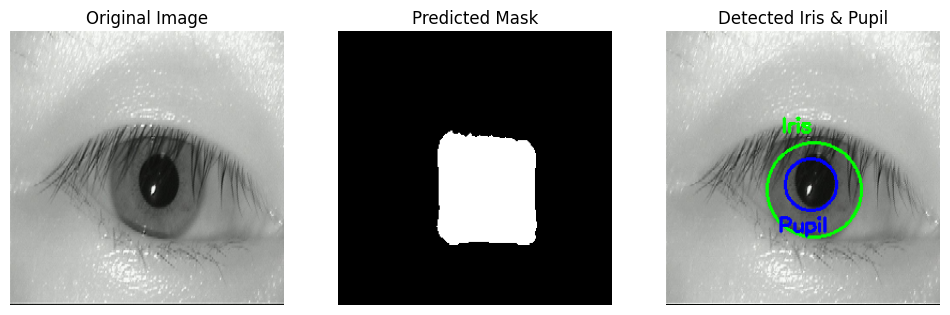

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the test image
image_path = "/content/drive/MyDrive/WhatsApp Image 2025-02-16 at 7.41.56 PM.jpeg"  # Update with your image path
new_test_image = cv2.imread(image_path)
new_test_image = cv2.resize(new_test_image, (256, 256))  # Resize to match model input
original_image = new_test_image.copy()  # Keep a copy for visualization

# Normalize and predict
new_test_image = new_test_image / 255.0  # Normalize
new_test_image = np.expand_dims(new_test_image, axis=0)  # Add batch dimension
predicted_mask = unet_model.predict(new_test_image)
predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to binary and remove batch dim

# Convert predicted mask to uint8
binary_mask = (predicted_mask * 255).astype(np.uint8)

# Find contours
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

iris_contour = None
pupil_contour = None
iris_radius = None
pupil_radius = None

# Sort contours by area (largest should be iris)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

if len(sorted_contours) > 0:
    iris_contour = sorted_contours[0]  # Largest contour (Iris)

    # Extract iris region
    mask = np.zeros_like(binary_mask)
    cv2.drawContours(mask, [iris_contour], -1, 255, thickness=cv2.FILLED)
    iris_region = cv2.bitwise_and(binary_mask, binary_mask, mask=mask)

    # Convert iris region to grayscale for pupil detection
    gray_iris = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    pupil_region = cv2.bitwise_and(gray_iris, gray_iris, mask=mask)

    # Use HoughCircles to detect the pupil more accurately
    circles = cv2.HoughCircles(pupil_region, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=3, maxRadius=30)  # Smaller radii

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            x, y, r = i
            iris_x, iris_y, iris_w, iris_h = cv2.boundingRect(iris_contour)

            # Ensure the detected pupil is within the iris
            if iris_x < x < iris_x + iris_w and iris_y < y < iris_y + iris_h:
                pupil_contour = (x, y, r)
                pupil_radius = r  # Store pupil radius
                break

# Draw iris circle using centroid & radius
if iris_contour is not None:
    M = cv2.moments(iris_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        iris_radius = int(0.85 * np.sqrt(cv2.contourArea(iris_contour) / np.pi))  # Larger radius
        cv2.circle(original_image, (cx, cy), iris_radius, (0, 255, 0), 2)  # Green for iris

        # Move iris label **above** the iris
        iris_label_x = cx - 30
        iris_label_y = cy - iris_radius - 10  # Move text higher
        cv2.putText(original_image, "Iris", (iris_label_x, iris_label_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Draw pupil circle using HoughCircles
if pupil_contour is not None:
    x, y, r = pupil_contour
    cv2.circle(original_image, (x, y), max(2, r - 5), (255, 0, 0), 2)  # Smaller pupil circle

    # Move pupil label **below** the pupil
    pupil_label_x = x - 30
    pupil_label_y = y + r + 15  # Move text lower
    cv2.putText(original_image, "Pupil", (pupil_label_x, pupil_label_y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Calculate Iris-to-Pupil Ratio (Only print, don't display on image)
if iris_radius is not None and pupil_radius is not None and pupil_radius > 0:
    iris_to_pupil_ratio = iris_radius / pupil_radius
    print(f"✅ Iris-to-Pupil Ratio: {iris_to_pupil_ratio:.2f}")

# Visualization
plt.figure(figsize=(12, 6))

# Show original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Show predicted mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

# Show processed image with detections
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Iris & Pupil")
plt.axis("off")

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Load test images and ground truth masks (update paths accordingly)
image_path = "/content/drive/MyDrive/Dataset/download.jpg"  # Change this
mask_path = "/content/drive/MyDrive/predicted_mask.png"  # Ground truth mask

# Load and preprocess test image
test_img = cv2.imread(image_path)
test_img = cv2.resize(test_img, (256, 256))  # Resize to model input size
test_img = test_img / 255.0  # Normalize
test_img = np.expand_dims(test_img, axis=0)  # Add batch dimension

# Load and preprocess ground truth mask
gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = cv2.resize(gt_mask, (256, 256))  # Ensure same size
gt_mask = (gt_mask > 127).astype(np.uint8)  # Convert to binary (0 or 1)

# Make prediction
pred_mask = unet_model.predict(test_img)[0]  # Remove batch dimension
pred_mask = np.argmax(pred_mask, axis=-1)  # Convert from one-hot to binary mask

# Flatten for metric calculations
gt_mask_flat = gt_mask.flatten()
pred_mask_flat = pred_mask.flatten()

# Compute evaluation metrics
iou_score = jaccard_score(gt_mask_flat, pred_mask_flat)
dice_score = (2 * np.sum(gt_mask_flat * pred_mask_flat)) / (np.sum(gt_mask_flat) + np.sum(pred_mask_flat) + 1e-7)
precision = precision_score(gt_mask_flat, pred_mask_flat)
recall = recall_score(gt_mask_flat, pred_mask_flat)
f1 = f1_score(gt_mask_flat, pred_mask_flat)
pixel_accuracy = np.mean(gt_mask_flat == pred_mask_flat)  # Pixel-wise accuracy

# Print results
print(f"✅ IoU Score: {iou_score:.4f}")
print(f"✅ Dice Coefficient: {dice_score:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Pixel Accuracy: {pixel_accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ IoU Score: 0.6507
✅ Dice Coefficient: 0.7884
✅ Precision: 0.6507
✅ Recall: 1.0000
✅ F1 Score: 0.7884
✅ Pixel Accuracy: 0.8374


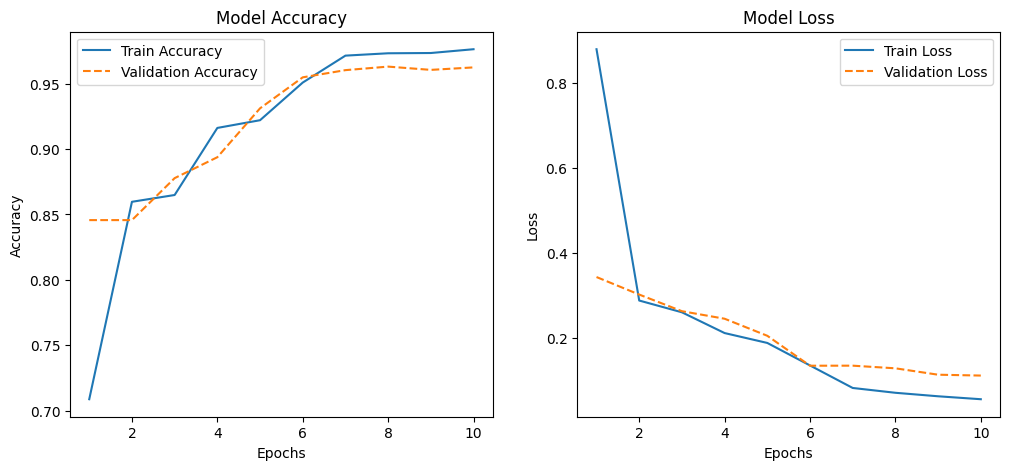

In [ ]:
import matplotlib.pyplot as plt

# Manually extract values from logs (example based on your output)
epochs = range(1, 11)  # Since you trained for 10 epochs
train_accuracy = [0.7087, 0.8597, 0.8649, 0.9162, 0.9221, 0.9509, 0.9715, 0.9733, 0.9735, 0.9764]
val_accuracy = [0.8457, 0.8457, 0.8778, 0.8938, 0.9312, 0.9549, 0.9604, 0.9631, 0.9606, 0.9625]

train_loss = [0.8783, 0.2888, 0.2612, 0.2125, 0.1893, 0.1365, 0.0837, 0.0724, 0.0642, 0.0573]
val_loss = [0.3439, 0.3028, 0.2638, 0.2461, 0.2061, 0.1359, 0.1360, 0.1298, 0.1148, 0.1128]

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label="Train Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()


In [ ]:
from IPython.core.display import display, HTML

# Convert DataFrame to HTML with styling
html_table = df.to_html(index=False, border=1)

# Display in Colab
display(HTML(html_table))



IoU Score,Dice Coefficient,Precision,Recall,F1 Score,Pixel Accuracy
0.6507,0.7884,0.6507,1.0,0.7884,0.8374


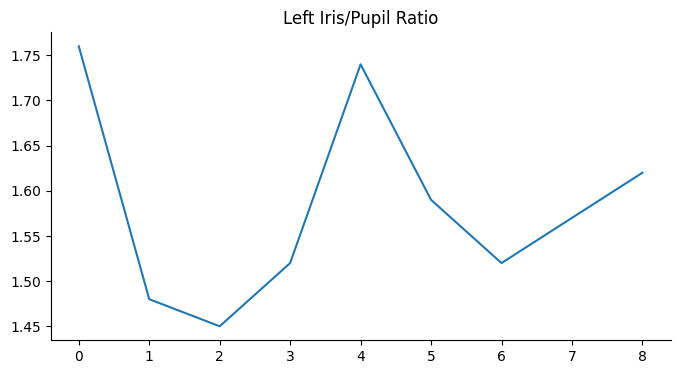

In [ ]:
# @title Left Iris/Pupil Ratio

from matplotlib import pyplot as plt
df['Left Iris/Pupil Ratio'].plot(kind='line', figsize=(8, 4), title='Left Iris/Pupil Ratio')
plt.gca().spines[['top', 'right']].set_visible(False)

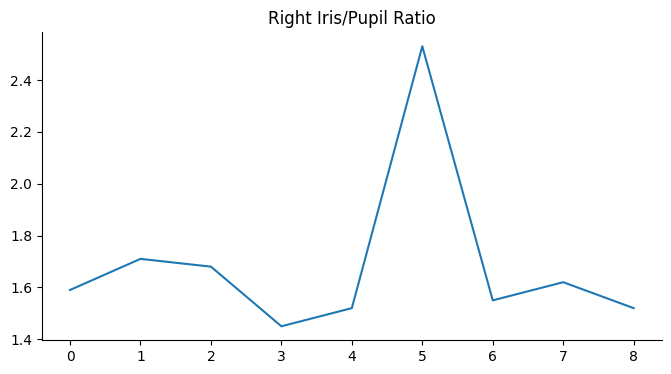

In [ ]:
# @title Right Iris/Pupil Ratio

from matplotlib import pyplot as plt
df['Right Iris/Pupil Ratio'].plot(kind='line', figsize=(8, 4), title='Right Iris/Pupil Ratio')
plt.gca().spines[['top', 'right']].set_visible(False)